In [32]:
import numpy as np
import pandas as pd
from collections import deque
import random

import tensorflow.keras as keras
import tensorflow as tf

from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


In [33]:
# set print decimal precision
np.set_printoptions(precision=3, suppress=True)

# read processed csv
data = pd.read_csv("postprocessed.csv") 
data.head()

,entityId,timestamp,current,lampIsRunning,voltage,ttf,ttf_label
0,Test1,2019-11-05 09:19:17,0.000000,False,0.000000,0,failure
1,Test1,2019-11-05 09:19:17,0.000000,False,0.000000,0,failure
2,Test1,2019-11-04 23:40:46,0.635923,True,0.193141,400,>2min
3,Test1,2019-11-04 23:40:46,0.635923,True,0.205487,399,>2min
4,Test1,2019-11-04 23:40:44,0.631302,True,0.205487,398,>2min


In [34]:
ttf_labels = ["failure", "<30sec", "<1min", "1-2min", ">2min"]

In [35]:
# remove unnecessary features
data.drop(columns="entityId", inplace=True)
data.drop(columns="timestamp", inplace=True)
data.drop(columns="lampIsRunning", inplace=True)
data.drop(columns="ttf", inplace=True)

data

,current,voltage,ttf_label
0,0.000000,0.000000,failure
1,0.000000,0.000000,failure
2,0.635923,0.193141,>2min
3,0.635923,0.205487,>2min
4,0.631302,0.205487,>2min
...,...,...,...
1092,0.674761,0.194146,<30sec
1093,0.675624,0.201216,<30sec
1094,0.674805,0.210227,failure
1095,0.000000,0.000000,failure


In [36]:
# build time-series sequences with given sequence length

SEQ_LEN = 20

sequential_data = []
prev_measures = deque(maxlen=SEQ_LEN)

for i in data.values:  # iterate over the values
        prev_measures.append([n for n in i[:-1]])  # store all but the target
        if len(prev_measures) == SEQ_LEN: 
            sequential_data.append([np.array(prev_measures), i[-1]])

random.shuffle(sequential_data)

sequential_data[2]

[array([[0.643, 0.21 ],
        [0.648, 0.21 ],
        [0.648, 0.203],
        [0.654, 0.215],
        [0.654, 0.21 ],
        [0.654, 0.21 ],
        [0.65 , 0.202],
        [0.65 , 0.21 ],
        [0.65 , 0.21 ],
        [0.65 , 0.208],
        [0.653, 0.208],
        [0.653, 0.2  ],
        [0.654, 0.2  ],
        [0.654, 0.198],
        [0.657, 0.198],
        [0.657, 0.204],
        [0.661, 0.204],
        [0.661, 0.209],
        [0.661, 0.209],
        [0.661, 0.222]]), '>2min']

In [37]:
# create training data set

X = []
y = []

y_dictionary = {
    "failure": [1.0, 0.0, 0.0, 0.0 ,0.0],
    "<30sec": [0.0, 1.0, 0.0, 0.0 ,0.0],
    "<1min": [0.0, 0.0, 1.0, 0.0 ,0.0],
    "1-2min": [0.0, 0.0, 0.0, 1.0 ,0.0],
    ">2min": [0.0, 0.0, 0.0, 0.0 ,1.0]
}

for seq, target in sequential_data: 
    X.append(seq.ravel())
    y.append(y_dictionary[target])

train_x = np.array(X)
train_y = np.array(y)


X, X_test, Y, y_test = train_test_split(train_x, train_y, test_size=0.33)

In [38]:
# create and train model

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(train_x.shape[1], input_dim=train_x.shape[1], activation="relu"))
model.add(tf.keras.layers.Dense(24, input_dim=24, activation="relu"))
model.add(tf.keras.layers.Dense(5, activation="softmax"))

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X, Y, epochs=1000, validation_split = 0.2)

Train on 577 samples, validate on 145 samples
Epoch 1/1000
577/577 [==============================] - 0s 259us/sample - loss: 1.4784 - acc: 0.4055 - val_loss: 1.3216 - val_acc: 0.4414
Epoch 2/1000
577/577 [==============================] - 0s 57us/sample - loss: 1.2419 - acc: 0.5061 - val_loss: 1.2242 - val_acc: 0.4414
Epoch 3/1000
577/577 [==============================] - 0s 82us/sample - loss: 1.1864 - acc: 0.5303 - val_loss: 1.1911 - val_acc: 0.4621
Epoch 4/1000
577/577 [==============================] - 0s 62us/sample - loss: 1.1529 - acc: 0.5373 - val_loss: 1.1743 - val_acc: 0.4828
Epoch 5/1000
577/577 [==============================] - 0s 68us/sample - loss: 1.1387 - acc: 0.5615 - val_loss: 1.1592 - val_acc: 0.5103
Epoch 6/1000
577/577 [==============================] - 0s 71us/sample - loss: 1.1257 - acc: 0.5789 - val_loss: 1.1603 - val_acc: 0.5103
Epoch 7/1000
577/577 [==============================] - 0s 63us/sample - loss: 1.1146 - acc: 0.5737 - val_loss: 1.1658 - val_acc: 0

577/577 [==============================] - 0s 58us/sample - loss: 0.8732 - acc: 0.6534 - val_loss: 0.9506 - val_acc: 0.5586
Epoch 61/1000
577/577 [==============================] - 0s 70us/sample - loss: 0.8668 - acc: 0.6655 - val_loss: 0.9248 - val_acc: 0.5931
Epoch 62/1000
577/577 [==============================] - 0s 67us/sample - loss: 0.8731 - acc: 0.6846 - val_loss: 0.9273 - val_acc: 0.5724
Epoch 63/1000
577/577 [==============================] - 0s 62us/sample - loss: 0.8759 - acc: 0.6551 - val_loss: 0.9390 - val_acc: 0.5862
Epoch 64/1000
577/577 [==============================] - 0s 68us/sample - loss: 0.8643 - acc: 0.6568 - val_loss: 0.9276 - val_acc: 0.5931
Epoch 65/1000
577/577 [==============================] - 0s 60us/sample - loss: 0.8539 - acc: 0.6742 - val_loss: 0.9243 - val_acc: 0.5931
Epoch 66/1000
577/577 [==============================] - 0s 63us/sample - loss: 0.8540 - acc: 0.6724 - val_loss: 0.9192 - val_acc: 0.5862
Epoch 67/1000
577/577 [=========================

577/577 [==============================] - 0s 66us/sample - loss: 0.8136 - acc: 0.6707 - val_loss: 0.8721 - val_acc: 0.6276
Epoch 120/1000
577/577 [==============================] - 0s 79us/sample - loss: 0.8105 - acc: 0.6967 - val_loss: 0.8485 - val_acc: 0.6069
Epoch 121/1000
577/577 [==============================] - 0s 76us/sample - loss: 0.7846 - acc: 0.7158 - val_loss: 0.8433 - val_acc: 0.6690
Epoch 122/1000
577/577 [==============================] - 0s 63us/sample - loss: 0.7998 - acc: 0.7140 - val_loss: 0.8561 - val_acc: 0.5793
Epoch 123/1000
577/577 [==============================] - 0s 63us/sample - loss: 0.8842 - acc: 0.6499 - val_loss: 0.8766 - val_acc: 0.6000
Epoch 124/1000
577/577 [==============================] - 0s 63us/sample - loss: 0.8197 - acc: 0.6690 - val_loss: 0.8661 - val_acc: 0.5931
Epoch 125/1000
577/577 [==============================] - 0s 57us/sample - loss: 0.8316 - acc: 0.6672 - val_loss: 0.9337 - val_acc: 0.6138
Epoch 126/1000
577/577 [==================

577/577 [==============================] - 0s 62us/sample - loss: 0.7573 - acc: 0.7002 - val_loss: 0.7984 - val_acc: 0.6759
Epoch 179/1000
577/577 [==============================] - 0s 69us/sample - loss: 0.7237 - acc: 0.7279 - val_loss: 0.8116 - val_acc: 0.5793
Epoch 180/1000
577/577 [==============================] - 0s 55us/sample - loss: 0.7642 - acc: 0.6984 - val_loss: 0.7761 - val_acc: 0.6621
Epoch 181/1000
577/577 [==============================] - 0s 64us/sample - loss: 0.8210 - acc: 0.6690 - val_loss: 0.8699 - val_acc: 0.6138
Epoch 182/1000
577/577 [==============================] - 0s 56us/sample - loss: 0.7349 - acc: 0.6898 - val_loss: 0.8758 - val_acc: 0.6138
Epoch 183/1000
577/577 [==============================] - 0s 72us/sample - loss: 0.7229 - acc: 0.7140 - val_loss: 0.7688 - val_acc: 0.6759
Epoch 184/1000
577/577 [==============================] - 0s 76us/sample - loss: 0.7093 - acc: 0.7400 - val_loss: 0.7747 - val_acc: 0.6414
Epoch 185/1000
577/577 [==================

Epoch 237/1000
577/577 [==============================] - 0s 68us/sample - loss: 0.6467 - acc: 0.7556 - val_loss: 0.7264 - val_acc: 0.7103
Epoch 238/1000
577/577 [==============================] - 0s 56us/sample - loss: 0.6588 - acc: 0.7643 - val_loss: 0.7236 - val_acc: 0.7034
Epoch 239/1000
577/577 [==============================] - 0s 64us/sample - loss: 0.6598 - acc: 0.7435 - val_loss: 0.7451 - val_acc: 0.6621
Epoch 240/1000
577/577 [==============================] - 0s 47us/sample - loss: 0.6969 - acc: 0.7435 - val_loss: 0.7133 - val_acc: 0.7034
Epoch 241/1000
577/577 [==============================] - 0s 71us/sample - loss: 0.6414 - acc: 0.7522 - val_loss: 0.7009 - val_acc: 0.6897
Epoch 242/1000
577/577 [==============================] - 0s 60us/sample - loss: 0.6277 - acc: 0.7712 - val_loss: 0.6802 - val_acc: 0.7172
Epoch 243/1000
577/577 [==============================] - 0s 56us/sample - loss: 0.6222 - acc: 0.7747 - val_loss: 0.7218 - val_acc: 0.7172
Epoch 244/1000
577/577 [===

Epoch 296/1000
577/577 [==============================] - 0s 97us/sample - loss: 0.5578 - acc: 0.8146 - val_loss: 0.6009 - val_acc: 0.7448
Epoch 297/1000
577/577 [==============================] - 0s 92us/sample - loss: 0.6120 - acc: 0.7782 - val_loss: 0.6097 - val_acc: 0.7793
Epoch 298/1000
577/577 [==============================] - 0s 73us/sample - loss: 0.5636 - acc: 0.8267 - val_loss: 0.6441 - val_acc: 0.7241
Epoch 299/1000
577/577 [==============================] - 0s 69us/sample - loss: 0.5609 - acc: 0.8024 - val_loss: 0.6164 - val_acc: 0.7517
Epoch 300/1000
577/577 [==============================] - 0s 75us/sample - loss: 0.5746 - acc: 0.7851 - val_loss: 0.5899 - val_acc: 0.8414
Epoch 301/1000
577/577 [==============================] - 0s 70us/sample - loss: 0.5621 - acc: 0.8267 - val_loss: 0.5847 - val_acc: 0.8483
Epoch 302/1000
577/577 [==============================] - 0s 70us/sample - loss: 0.5494 - acc: 0.8180 - val_loss: 0.6383 - val_acc: 0.7379
Epoch 303/1000
577/577 [===

577/577 [==============================] - 0s 61us/sample - loss: 0.4971 - acc: 0.8388 - val_loss: 0.5509 - val_acc: 0.8000
Epoch 355/1000
577/577 [==============================] - 0s 70us/sample - loss: 0.4931 - acc: 0.8510 - val_loss: 0.5203 - val_acc: 0.8207
Epoch 356/1000
577/577 [==============================] - 0s 71us/sample - loss: 0.4859 - acc: 0.8388 - val_loss: 0.5310 - val_acc: 0.8069
Epoch 357/1000
577/577 [==============================] - 0s 71us/sample - loss: 0.4854 - acc: 0.8423 - val_loss: 0.5121 - val_acc: 0.8207
Epoch 358/1000
577/577 [==============================] - 0s 72us/sample - loss: 0.4808 - acc: 0.8683 - val_loss: 0.5200 - val_acc: 0.8345
Epoch 359/1000
577/577 [==============================] - 0s 67us/sample - loss: 0.5087 - acc: 0.8388 - val_loss: 0.5289 - val_acc: 0.8207
Epoch 360/1000
577/577 [==============================] - 0s 61us/sample - loss: 0.4899 - acc: 0.8354 - val_loss: 0.5874 - val_acc: 0.7448
Epoch 361/1000
577/577 [==================

577/577 [==============================] - 0s 86us/sample - loss: 0.4418 - acc: 0.8596 - val_loss: 0.4663 - val_acc: 0.8207
Epoch 414/1000
577/577 [==============================] - 0s 81us/sample - loss: 0.4711 - acc: 0.8510 - val_loss: 0.4879 - val_acc: 0.8414
Epoch 415/1000
577/577 [==============================] - 0s 76us/sample - loss: 0.4414 - acc: 0.8735 - val_loss: 0.4706 - val_acc: 0.8690
Epoch 416/1000
577/577 [==============================] - 0s 77us/sample - loss: 0.4391 - acc: 0.8821 - val_loss: 0.5603 - val_acc: 0.7724
Epoch 417/1000
577/577 [==============================] - 0s 76us/sample - loss: 0.4360 - acc: 0.8666 - val_loss: 0.4653 - val_acc: 0.8483
Epoch 418/1000
577/577 [==============================] - 0s 76us/sample - loss: 0.4268 - acc: 0.8735 - val_loss: 0.4613 - val_acc: 0.8552
Epoch 419/1000
577/577 [==============================] - 0s 72us/sample - loss: 0.4372 - acc: 0.8700 - val_loss: 0.5463 - val_acc: 0.7724
Epoch 420/1000
577/577 [==================

577/577 [==============================] - 0s 77us/sample - loss: 0.4192 - acc: 0.8648 - val_loss: 0.5183 - val_acc: 0.7862
Epoch 473/1000
577/577 [==============================] - 0s 66us/sample - loss: 0.4117 - acc: 0.8596 - val_loss: 0.4390 - val_acc: 0.8207
Epoch 474/1000
577/577 [==============================] - 0s 64us/sample - loss: 0.4245 - acc: 0.8336 - val_loss: 0.4783 - val_acc: 0.7655
Epoch 475/1000
577/577 [==============================] - 0s 68us/sample - loss: 0.4066 - acc: 0.8718 - val_loss: 0.4822 - val_acc: 0.8138
Epoch 476/1000
577/577 [==============================] - 0s 52us/sample - loss: 0.5170 - acc: 0.7730 - val_loss: 0.4606 - val_acc: 0.7931
Epoch 477/1000
577/577 [==============================] - 0s 70us/sample - loss: 0.4035 - acc: 0.8614 - val_loss: 0.4309 - val_acc: 0.8414
Epoch 478/1000
577/577 [==============================] - 0s 72us/sample - loss: 0.4091 - acc: 0.8683 - val_loss: 0.5021 - val_acc: 0.7931
Epoch 479/1000
577/577 [==================

577/577 [==============================] - 0s 103us/sample - loss: 0.3765 - acc: 0.8769 - val_loss: 0.4275 - val_acc: 0.8759
Epoch 532/1000
577/577 [==============================] - 0s 71us/sample - loss: 0.3686 - acc: 0.8839 - val_loss: 0.4023 - val_acc: 0.8552
Epoch 533/1000
577/577 [==============================] - 0s 63us/sample - loss: 0.4322 - acc: 0.8388 - val_loss: 0.4450 - val_acc: 0.8552
Epoch 534/1000
577/577 [==============================] - 0s 76us/sample - loss: 0.3812 - acc: 0.8821 - val_loss: 0.3955 - val_acc: 0.8552
Epoch 535/1000
577/577 [==============================] - 0s 54us/sample - loss: 0.4078 - acc: 0.8527 - val_loss: 0.4757 - val_acc: 0.8000
Epoch 536/1000
577/577 [==============================] - 0s 64us/sample - loss: 0.4443 - acc: 0.8267 - val_loss: 0.4723 - val_acc: 0.8138
Epoch 537/1000
577/577 [==============================] - 0s 75us/sample - loss: 0.3924 - acc: 0.8769 - val_loss: 0.4320 - val_acc: 0.8690
Epoch 538/1000
577/577 [=================

577/577 [==============================] - 0s 61us/sample - loss: 0.3658 - acc: 0.8787 - val_loss: 0.3816 - val_acc: 0.8690
Epoch 591/1000
577/577 [==============================] - 0s 65us/sample - loss: 0.3560 - acc: 0.8891 - val_loss: 0.3914 - val_acc: 0.8621
Epoch 592/1000
577/577 [==============================] - 0s 51us/sample - loss: 0.3516 - acc: 0.8960 - val_loss: 0.3797 - val_acc: 0.8621
Epoch 593/1000
577/577 [==============================] - 0s 65us/sample - loss: 0.3730 - acc: 0.8631 - val_loss: 0.4095 - val_acc: 0.8207
Epoch 594/1000
577/577 [==============================] - 0s 52us/sample - loss: 0.4576 - acc: 0.8042 - val_loss: 0.4052 - val_acc: 0.8138
Epoch 595/1000
577/577 [==============================] - 0s 61us/sample - loss: 0.3644 - acc: 0.8769 - val_loss: 0.3790 - val_acc: 0.8759
Epoch 596/1000
577/577 [==============================] - 0s 60us/sample - loss: 0.3589 - acc: 0.8908 - val_loss: 0.4408 - val_acc: 0.8414
Epoch 597/1000
577/577 [==================

577/577 [==============================] - 0s 72us/sample - loss: 0.3693 - acc: 0.8666 - val_loss: 0.3813 - val_acc: 0.8690
Epoch 650/1000
577/577 [==============================] - 0s 89us/sample - loss: 0.3513 - acc: 0.8821 - val_loss: 0.4075 - val_acc: 0.8690
Epoch 651/1000
577/577 [==============================] - 0s 84us/sample - loss: 0.3582 - acc: 0.8752 - val_loss: 0.3834 - val_acc: 0.8828
Epoch 652/1000
577/577 [==============================] - 0s 70us/sample - loss: 0.3632 - acc: 0.8873 - val_loss: 0.4694 - val_acc: 0.8000
Epoch 653/1000
577/577 [==============================] - 0s 90us/sample - loss: 0.3910 - acc: 0.8683 - val_loss: 0.3769 - val_acc: 0.8483
Epoch 654/1000
577/577 [==============================] - 0s 95us/sample - loss: 0.4625 - acc: 0.8215 - val_loss: 0.7710 - val_acc: 0.6897
Epoch 655/1000
577/577 [==============================] - 0s 81us/sample - loss: 0.4814 - acc: 0.8128 - val_loss: 0.4020 - val_acc: 0.8690
Epoch 656/1000
577/577 [==================

Epoch 708/1000
577/577 [==============================] - 0s 60us/sample - loss: 0.3825 - acc: 0.8821 - val_loss: 0.3729 - val_acc: 0.8897
Epoch 709/1000
577/577 [==============================] - 0s 70us/sample - loss: 0.3425 - acc: 0.8960 - val_loss: 0.3645 - val_acc: 0.8828
Epoch 710/1000
577/577 [==============================] - 0s 63us/sample - loss: 0.3408 - acc: 0.8839 - val_loss: 0.3785 - val_acc: 0.8621
Epoch 711/1000
577/577 [==============================] - 0s 67us/sample - loss: 0.3382 - acc: 0.9029 - val_loss: 0.4370 - val_acc: 0.8207
Epoch 712/1000
577/577 [==============================] - 0s 86us/sample - loss: 0.3383 - acc: 0.8908 - val_loss: 0.3710 - val_acc: 0.8759
Epoch 713/1000
577/577 [==============================] - 0s 95us/sample - loss: 0.3325 - acc: 0.8925 - val_loss: 0.4463 - val_acc: 0.8207
Epoch 714/1000
577/577 [==============================] - 0s 95us/sample - loss: 0.3349 - acc: 0.8908 - val_loss: 0.4800 - val_acc: 0.7793
Epoch 715/1000
577/577 [===

Epoch 767/1000
577/577 [==============================] - 0s 75us/sample - loss: 0.5814 - acc: 0.7834 - val_loss: 0.6819 - val_acc: 0.7379
Epoch 768/1000
577/577 [==============================] - 0s 63us/sample - loss: 0.3667 - acc: 0.8700 - val_loss: 0.5047 - val_acc: 0.7862
Epoch 769/1000
577/577 [==============================] - 0s 76us/sample - loss: 0.3369 - acc: 0.8839 - val_loss: 0.3932 - val_acc: 0.8621
Epoch 770/1000
577/577 [==============================] - 0s 77us/sample - loss: 0.3291 - acc: 0.9012 - val_loss: 0.3536 - val_acc: 0.8759
Epoch 771/1000
577/577 [==============================] - 0s 71us/sample - loss: 0.3459 - acc: 0.8804 - val_loss: 0.3573 - val_acc: 0.8759
Epoch 772/1000
577/577 [==============================] - 0s 70us/sample - loss: 0.3334 - acc: 0.8925 - val_loss: 0.3680 - val_acc: 0.8690
Epoch 773/1000
577/577 [==============================] - 0s 72us/sample - loss: 0.3282 - acc: 0.9029 - val_loss: 0.3665 - val_acc: 0.8966
Epoch 774/1000
577/577 [===

Epoch 826/1000
577/577 [==============================] - 0s 64us/sample - loss: 0.3191 - acc: 0.8995 - val_loss: 0.5531 - val_acc: 0.7655
Epoch 827/1000
577/577 [==============================] - 0s 76us/sample - loss: 0.3875 - acc: 0.8631 - val_loss: 0.4112 - val_acc: 0.8414
Epoch 828/1000
577/577 [==============================] - 0s 72us/sample - loss: 0.3287 - acc: 0.8873 - val_loss: 0.3572 - val_acc: 0.8759
Epoch 829/1000
577/577 [==============================] - 0s 63us/sample - loss: 0.3216 - acc: 0.8925 - val_loss: 0.4539 - val_acc: 0.8138
Epoch 830/1000
577/577 [==============================] - 0s 67us/sample - loss: 0.3281 - acc: 0.8925 - val_loss: 0.3605 - val_acc: 0.8621
Epoch 831/1000
577/577 [==============================] - 0s 65us/sample - loss: 0.6980 - acc: 0.7608 - val_loss: 0.4346 - val_acc: 0.8138
Epoch 832/1000
577/577 [==============================] - 0s 76us/sample - loss: 0.3896 - acc: 0.8510 - val_loss: 0.3539 - val_acc: 0.8897
Epoch 833/1000
577/577 [===

577/577 [==============================] - 0s 112us/sample - loss: 0.4704 - acc: 0.8180 - val_loss: 0.4666 - val_acc: 0.7931
Epoch 885/1000
577/577 [==============================] - 0s 109us/sample - loss: 0.3499 - acc: 0.8700 - val_loss: 0.4835 - val_acc: 0.7931
Epoch 886/1000
577/577 [==============================] - 0s 124us/sample - loss: 0.3334 - acc: 0.8943 - val_loss: 0.3693 - val_acc: 0.8828
Epoch 887/1000
577/577 [==============================] - 0s 144us/sample - loss: 0.3180 - acc: 0.9029 - val_loss: 0.3812 - val_acc: 0.8828
Epoch 888/1000
577/577 [==============================] - 0s 96us/sample - loss: 0.3187 - acc: 0.9012 - val_loss: 0.3553 - val_acc: 0.8966
Epoch 889/1000
577/577 [==============================] - 0s 72us/sample - loss: 0.3160 - acc: 0.9047 - val_loss: 0.3643 - val_acc: 0.8828
Epoch 890/1000
577/577 [==============================] - 0s 76us/sample - loss: 0.3147 - acc: 0.9081 - val_loss: 0.4346 - val_acc: 0.8207
Epoch 891/1000
577/577 [==============

Epoch 943/1000
577/577 [==============================] - 0s 89us/sample - loss: 0.3136 - acc: 0.9099 - val_loss: 0.4367 - val_acc: 0.8138
Epoch 944/1000
577/577 [==============================] - 0s 117us/sample - loss: 0.3268 - acc: 0.8925 - val_loss: 0.3565 - val_acc: 0.8828
Epoch 945/1000
577/577 [==============================] - 0s 103us/sample - loss: 0.3144 - acc: 0.8995 - val_loss: 0.3845 - val_acc: 0.8690
Epoch 946/1000
577/577 [==============================] - 0s 76us/sample - loss: 0.3228 - acc: 0.8891 - val_loss: 0.4046 - val_acc: 0.8552
Epoch 947/1000
577/577 [==============================] - 0s 82us/sample - loss: 0.3154 - acc: 0.8995 - val_loss: 0.3420 - val_acc: 0.8828
Epoch 948/1000
577/577 [==============================] - 0s 73us/sample - loss: 0.3230 - acc: 0.8856 - val_loss: 0.3498 - val_acc: 0.8828
Epoch 949/1000
577/577 [==============================] - 0s 90us/sample - loss: 0.3067 - acc: 0.9064 - val_loss: 0.3417 - val_acc: 0.8897
Epoch 950/1000
577/577 [=

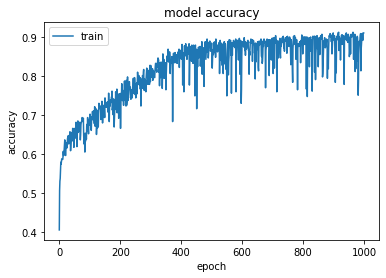

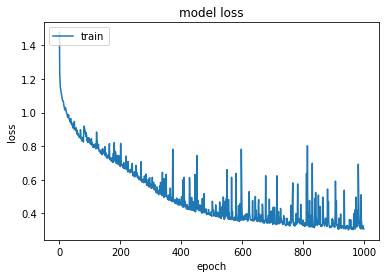

In [39]:
# display training results

plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
# "test" model

test_sequence_number = 6

prediction = model.predict(X_test)[test_sequence_number];
expected = y_test[test_sequence_number]

print("Expected value: ", ttf_labels[np.argmax(expected)], " ", expected)
print("Prediction: ", ttf_labels[np.argmax(prediction)], " ", prediction)

Expected value:  <30sec   [0. 1. 0. 0. 0.]
Prediction:  <30sec   [0.046 0.653 0.037 0.261 0.003]
